# Benchmarking of decomposition methods

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Hardware

- Sytem: Ubuntu 18.04.5 LTS
- CPU: Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz (12 cores)
- Disk: SAMSUNG MZ7LH960HAJR-00005 (SSD)
- RAM: 64G(32Gx2) DDR4 2666MHz
- GPU: RTX2080Ti (Driver Version: 495.29.05, CUDA Version: 11.5)

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27
- openTSNE==0.6.1

## Notation

1. **We fix parrel number here to ensure our tests are free from the fluctuation of our sever (it is not fair if we test UMAP with 10 free cores and test t-SNE with 2 free cores). For most of the cases, we fix n_jobs=6.**
2. **There are some other choices in density-based clustering, for example DENCLUE and CLIQUE. We choice DBSCAN, HDBSCAN, and OPTICS for accessbility: DBSCAN and OPTICS are implements in sklearn, and HDBSCAN can be installed via pip. For Windows users, HDBSCAN is not avilable from pypi, I recommend you to build the wheel downloaded from https://www.lfd.uci.edu/~gohlke/pythonlibs/.**

## 0. Configure the environment

In [1]:
import time
import tracemalloc  # monitor memory usage
import sys, os
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

tracemalloc.start()

# tested functions
import umap  # this is CPU-based UMAP, use cuML for GPU version
from sklearn import decomposition
from sklearn import manifold
from openTSNE import TSNE as OpenTSNE

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

# load table, used column=motif_F10
df = pd.read_csv("./Fly_dev_table.motif.F10.csv", index_col=[0,1,2], header=[0,1])
# Prior knowledge: NSUN6-like TCNA, else, NSUN2-like
df[("INFO", "Priori")] = "Type I"
df.loc[df[("INFO", "motif")].isin(["TCCA", "TCTA", "TCGA", "TCAA"]), ("INFO", "Priori")] = "Type II"
print(df)


                                                               INFO            \
                                                               ENSG      NAME   
2L@10007123@+                     FBgn0043456 CG4747    FBgn0043456    CG4747   
2L@10038800@+                     FBgn0027600 obst-B    FBgn0027600    obst-B   
2L@10058004@+                     FBgn0011823 Pen       FBgn0011823       Pen   
2L@101153@+                       FBgn0031216 CG11376   FBgn0031216   CG11376   
2L@1015176@-                      FBgn0031294 IA-2      FBgn0031294      IA-2   
...                                                             ...       ...   
XHet@68785@-                      FBgn0039945 CG17159   FBgn0039945   CG17159   
XHet@68786@-                      FBgn0039945 CG17159   FBgn0039945   CG17159   
XHet@77281@+                      FBgn0003559 su(f)     FBgn0003559     su(f)   
YHet@328017@-                     FBgn0085792 CR41509   FBgn0085792   CR41509   
dmel_mitochondrion_genome@14

## 1. One-hot encode sequence

In [2]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])

def onehot_enc(row):
    seq = [[i] for i in row[("INFO", "motif_F10")].upper()]
    # print(enc.transform(seq).toarray().reshape(-1))
    return enc.transform(seq).toarray().reshape(-1)

onehot_input = []
for idx, row in df.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)
print(onehot_input.shape)

(8402, 105)


## 2. Run clustering

### 2.1 PCA

In [3]:
def PCA(onehot_input, df):
    # very fast
    df = df.copy()
    
    print("PCA:")
    n_components= 10
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = decomposition.PCA(n_components=n_components, random_state=42)
    model.fit(onehot_input)
    pca_output = model.transform(onehot_input)
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.

    print("PCA explained variance percentages:")
    print(model.explained_variance_ratio_ * 100)
    print("PCA time: {} sec".format(time1))
    print("PCA RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = pca_output[:, 0]
    df["Y"] = pca_output[:, 1]
    del model
    return time1, mem, df


# three times:
t1, m1, _ = PCA(onehot_input, df)
t2, m2, _ = PCA(onehot_input, df)
t3, m3, df_PCA = PCA(onehot_input, df)
PCA_time = [t1, t2, t3]
PCA_mem = [m1, m2, m3]

PCA:
PCA explained variance percentages:
[4.24965816 3.19751783 3.12594642 2.5854117  2.53030406 2.43602538
 2.30462906 2.23321967 2.13952283 2.13141701]
PCA time: 0.1570725440979004 sec
PCA RAM: 14.854781150817871 MB

PCA:
PCA explained variance percentages:
[4.24965816 3.19751783 3.12594642 2.5854117  2.53030406 2.43602538
 2.30462906 2.23321967 2.13952283 2.13141701]
PCA time: 0.20853948593139648 sec
PCA RAM: 14.828023910522461 MB

PCA:
PCA explained variance percentages:
[4.24965816 3.19751783 3.12594642 2.5854117  2.53030406 2.43602538
 2.30462906 2.23321967 2.13952283 2.13141701]
PCA time: 0.16174745559692383 sec
PCA RAM: 14.827677726745605 MB



### 2.2 Locally Linear Embedding (LLE)

In [4]:
def LLE(onehot_input, df):
    # this should takes ~3 min
    df = df.copy()
    print("LLE:")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = manifold.LocallyLinearEmbedding(n_components=2, random_state=42, n_jobs=6)
    model.fit(onehot_input)
    LLE_output = model.fit_transform(onehot_input)
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("LLE time: {} sec".format(time1))
    print("LLE RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = LLE_output[:, 0]
    df["Y"] = LLE_output[:, 1]
    del model
    return time1, mem, df

t1, m1, _ = LLE(onehot_input, df)
t2, m2, _ = LLE(onehot_input, df)
t3, m3, df_LLE = LLE(onehot_input, df)
LLE_time = [t1, t2, t3]
LLE_mem = [m1, m2, m3]

LLE:
LLE time: 277.10355162620544 sec
LLE RAM: 42.35041427612305 MB

LLE:
LLE time: 278.0421779155731 sec
LLE RAM: 42.22931957244873 MB

LLE:
LLE time: 273.6498222351074 sec
LLE RAM: 42.21837329864502 MB



### 2.3 t-SNE

In [5]:
def tSNE(onehot_input, df):
    # fix n_jobs=6
    df = df.copy()
    print("t-SNE:")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = manifold.TSNE(n_components=2, init="random", verbose=False, random_state=42, n_jobs=6)
    model.fit(onehot_input)
    tSNE_output = model.fit_transform(onehot_input)
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("t-SNE time: {} sec".format(time1))
    print("t-SNE RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = tSNE_output[:, 0]
    df["Y"] = tSNE_output[:, 1]
    del model
    return time1, mem, df

t1, m1, _ = tSNE(onehot_input, df)
t2, m2, _ = tSNE(onehot_input, df)
t3, m3, df_tSNE = tSNE(onehot_input, df)
tSNE_time = [t1, t2, t3]
tSNE_mem = [m1, m2, m3]

t-SNE:
t-SNE time: 297.90143275260925 sec
t-SNE RAM: 47.34650707244873 MB

t-SNE:
t-SNE time: 275.325532913208 sec
t-SNE RAM: 47.347527503967285 MB

t-SNE:
t-SNE time: 244.9696774482727 sec
t-SNE RAM: 47.328529357910156 MB



### 2.4 Open t-SNE

In [6]:
def open_tSNE(onehot_input, df):
    # this should takes ~1.5 min
    df = df.copy()
    print("Open t-SNE:")
    time0 = time.time()
    current, _ = tracemalloc.get_traced_memory()
    
    model = OpenTSNE(n_components=2, verbose=False, random_state=42, n_jobs=6)
    model.fit(onehot_input)
    tSNE_output = model.fit(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("Open t-SNE time: {} sec".format(time1))
    print("Open t-SNE RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = tSNE_output[:, 0]
    df["Y"] = tSNE_output[:, 1]
    del model
    return time1, mem, df

t1, m1, _ = open_tSNE(onehot_input, df)
t2, m2, _ = open_tSNE(onehot_input, df)
t3, m3, df_OpenTSNE = open_tSNE(onehot_input, df)
OpenTSNE_time = [t1, t2, t3]
OpenTSNE_mem = [m1, m2, m3]

Open t-SNE:
Open t-SNE time: 53.0809600353241 sec
Open t-SNE RAM: 60.033376693725586 MB

Open t-SNE:
Open t-SNE time: 53.2645263671875 sec
Open t-SNE RAM: 59.992173194885254 MB

Open t-SNE:
Open t-SNE time: 53.292433738708496 sec
Open t-SNE RAM: 59.98701095581055 MB



### 2.5 UMAP (native)

In [7]:
def UMAP(onehot_input, df):
    # this should takes ~20 sec  
    df = df.copy()
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=0.01, n_neighbors=20, verbose=False, n_jobs=6)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

t1, m1, _ = UMAP(onehot_input, df)
t2, m2, _ = UMAP(onehot_input, df)
t3, m3, df_UMAP = UMAP(onehot_input, df)
UMAP_time = [t1, t2, t3]
UMAP_mem = [m1, m2, m3]


UMAP
UMAP time: 66.10749578475952 sec
UMAP RAM: 79.510498046875 MB

UMAP
UMAP time: 27.844027280807495 sec
UMAP RAM: 42.618980407714844 MB

UMAP
UMAP time: 27.51863169670105 sec
UMAP RAM: 54.522430419921875 MB



### 2.6 DensMAP (Density-Preserving UMAP)

In [8]:
def densMAP(onehot_input, df):
    # this should takes ~40 sec
    print("DensMAP")
    df = df.copy()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=0.01, n_neighbors=20, verbose=False, densmap=True, n_jobs=6)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    time1 = time.time() - time0
    print("DensMAP time: {} sec".format(time1))
    print("DensMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

t1, m1, _ = densMAP(onehot_input, df)
t2, m2, _ = densMAP(onehot_input, df)
t3, m3, df_densUMAP = densMAP(onehot_input, df)
densUMAP_time = [t1, t2, t3]
densUMAP_mem = [m1, m2, m3]

DensMAP
DensMAP time: 59.31463694572449 sec
DensMAP RAM: 87.26604175567627 MB

DensMAP
DensMAP time: 59.573585748672485 sec
DensMAP RAM: 73.40502071380615 MB

DensMAP
DensMAP time: 59.66349411010742 sec
DensMAP RAM: 85.28321266174316 MB



## 3. Bechmarking

### 3.1 Comparing runtime

        Method  Time (seconds)
0          PCA        0.157073
1          PCA        0.208539
2          PCA        0.161747
3          LLE      277.103552
4          LLE      278.042178
5          LLE      273.649822
6        t-SNE      297.901433
7        t-SNE      275.325533
8        t-SNE      244.969677
9   open t-SNE       53.080960
10  open t-SNE       53.264526
11  open t-SNE       53.292434
12        UMAP       66.107496
13        UMAP       27.844027
14        UMAP       27.518632
15     DensMAP       59.314637
16     DensMAP       59.573586
17     DensMAP       59.663494


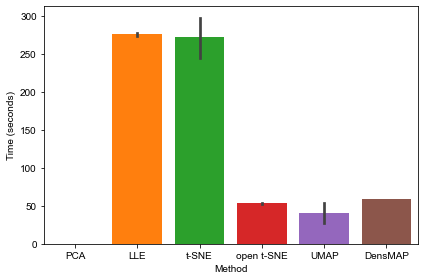

In [9]:
fig, ax = plt.subplots()
df_time = pd.DataFrame([PCA_time, LLE_time, tSNE_time, OpenTSNE_time, UMAP_time, densUMAP_time], index=["PCA", "LLE", "t-SNE", "open t-SNE", "UMAP", "DensMAP"]).T
df_time = df_time.melt(var_name="Method", value_name="Time (seconds)")

# saving results to disk
df_time.to_csv("Decomposition_runtime.csv")

print(df_time)
sns.barplot(data=df_time, x="Method", y="Time (seconds)", ax=ax, saturation=1)

plt.tight_layout()
plt.savefig("Decomposition_runtime.pdf")
plt.show()

### 3.2 Memory usage

        Method  Peak Memory (MB)
0          PCA         14.854781
1          PCA         14.828024
2          PCA         14.827678
3          LLE         42.350414
4          LLE         42.229320
5          LLE         42.218373
6        t-SNE         47.346507
7        t-SNE         47.347528
8        t-SNE         47.328529
9   open t-SNE         60.033377
10  open t-SNE         59.992173
11  open t-SNE         59.987011
12        UMAP         79.510498
13        UMAP         42.618980
14        UMAP         54.522430
15     DensMAP         87.266042
16     DensMAP         73.405021
17     DensMAP         85.283213


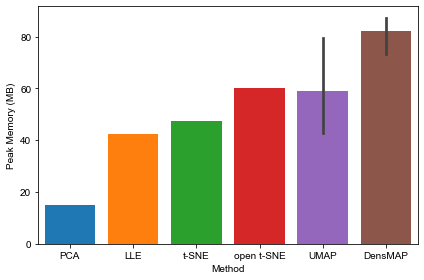

In [10]:
fig, ax = plt.subplots()
df_mem = pd.DataFrame([PCA_mem, LLE_mem, tSNE_mem, OpenTSNE_mem, UMAP_mem, densUMAP_mem], index=["PCA", "LLE", "t-SNE", "open t-SNE", "UMAP", "DensMAP"]).T
df_mem = df_mem.melt(var_name="Method", value_name="Peak Memory (MB)")

# saving results to disk
df_mem.to_csv("Decomposition_Mem.csv")

print(df_mem)
sns.barplot(data=df_mem, x="Method", y="Peak Memory (MB)", ax=ax, saturation=1)
plt.tight_layout()
plt.savefig("Decomposition_Mem.pdf")
plt.show()

### 3.3 Draw scatters

In [11]:
def draw_clusters(ax, df, xlabel, ylabel, title, save_table=True):
    # blue - Type I
    # red  - Type II
    df_TypeI = df[df[("INFO", "Priori")]=="Type I"]
    df_TypeII = df[df[("INFO", "Priori")]=="Type II"]
    
    # draw scatter
    ax.scatter(df_TypeI["X"], df_TypeI["Y"], label="Type I", s=1, c="#4C7FB4")
    ax.scatter(df_TypeII["X"], df_TypeII["Y"], label="Type II", s=1, c="#BD4651")
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if save_table == True:
        df.to_csv("{}.csv".format(title.replace(" ","_")))

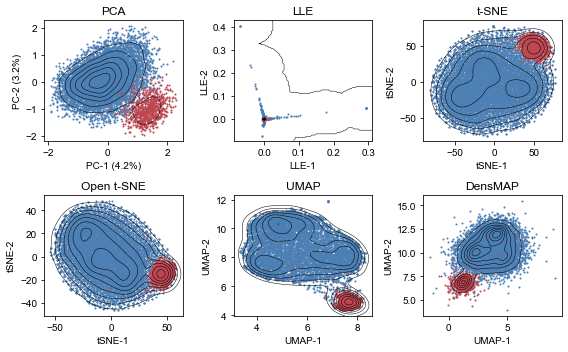

In [12]:
fig, axes = plt.subplots(2,3, figsize=(8,5))
draw_clusters(axes[0][0], df_PCA, "PC-1 (4.2%)", "PC-2 (3.2%)", "PCA")
draw_clusters(axes[0][1], df_LLE, "LLE-1", "LLE-2", "LLE")
draw_clusters(axes[0][2], df_tSNE, "tSNE-1", "tSNE-2", "t-SNE")
draw_clusters(axes[1][0], df_OpenTSNE, "tSNE-1", "tSNE-2", "Open t-SNE")
draw_clusters(axes[1][1], df_UMAP, "UMAP-1", "UMAP-2", "UMAP")
draw_clusters(axes[1][2], df_densUMAP, "UMAP-1", "UMAP-2", "DensMAP")
plt.tight_layout()

plt.savefig("Decomposition_scatter.pdf")

## 4. Comparing UMAP metrics for onehot-encoded data

In [13]:
def UMAP_metrics(onehot_input, df, metric=None):
    # this should takes ~20 sec  
    df = df.copy()
    print("Metric = {}".format(metric))
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42,  n_components=2, min_dist=0.01, n_neighbors=20, verbose=False, metric=metric, n_jobs=6)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df
# minkowski style
metrics_set1 = ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
# binary
metrics_set2 = ['hamming', 'dice', 'jaccard', 'dice', 'russellrao', 'kulsinski', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule']

### 4.1 Test Minkowski-style ones

In [14]:
UMAP_out = []
Time_out = []
MEM_out = []
for m in metrics_set1:
    for _ in range(3):
        time1, mem, df_out = UMAP_metrics(onehot_input, df, metric=m)
        Time_out.append(time1)
        MEM_out.append(mem)
    UMAP_out.append(df_out.copy())

Metric = euclidean
UMAP time: 27.52726459503174 sec
UMAP RAM: 87.18525981903076 MB

Metric = euclidean
UMAP time: 27.627380847930908 sec
UMAP RAM: 75.08754253387451 MB

Metric = euclidean
UMAP time: 27.782577514648438 sec
UMAP RAM: 69.09958457946777 MB

Metric = manhattan
UMAP time: 37.7425012588501 sec
UMAP RAM: 76.67847061157227 MB

Metric = manhattan
UMAP time: 27.242331981658936 sec
UMAP RAM: 61.76513957977295 MB

Metric = manhattan
UMAP time: 27.74483871459961 sec
UMAP RAM: 57.21544361114502 MB

Metric = minkowski
UMAP time: 37.420175552368164 sec
UMAP RAM: 68.66375064849854 MB

Metric = minkowski
UMAP time: 27.146674394607544 sec
UMAP RAM: 53.54033088684082 MB

Metric = minkowski
UMAP time: 27.540719509124756 sec
UMAP RAM: 47.14650535583496 MB

Metric = chebyshev
UMAP time: 84.23543953895569 sec
UMAP RAM: 93.25289916992188 MB

Metric = chebyshev
UMAP time: 73.67953896522522 sec
UMAP RAM: 82.14410209655762 MB

Metric = chebyshev
UMAP time: 73.98842167854309 sec
UMAP RAM: 82.138546

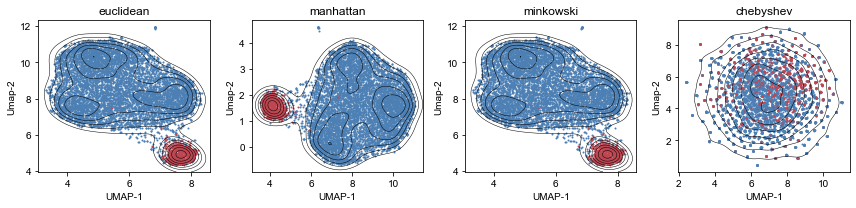

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))
for ax, df, m in zip(*[axes.reshape(-1), UMAP_out, metrics_set1]):
    draw_clusters(ax, df, "UMAP-1", "Umap-2", m)
plt.tight_layout()
plt.savefig("Decomposition_UMAP_metrics.Minkowski.pdf")

### 4.2 Test binary metrics

In [16]:
# too noisy, supress warnings
import warnings
warnings.filterwarnings('ignore')

UMAP_out2 = []
Time_out2 = []
MEM_out2 = []
for m in metrics_set2:
    for _ in range(3):
        time1, mem, df_out = UMAP_metrics(onehot_input, df, metric=m)
        Time_out2.append(time1)
        MEM_out2.append(mem)
    UMAP_out2.append(df_out.copy())

Metric = hamming
UMAP time: 37.873037338256836 sec
UMAP RAM: 100.29790115356445 MB

Metric = hamming
UMAP time: 27.28966999053955 sec
UMAP RAM: 87.9651288986206 MB

Metric = hamming
UMAP time: 27.566513538360596 sec
UMAP RAM: 81.58712577819824 MB

Metric = dice
UMAP time: 37.75940656661987 sec
UMAP RAM: 97.18797302246094 MB

Metric = dice
UMAP time: 27.449172735214233 sec
UMAP RAM: 83.33523082733154 MB

Metric = dice
UMAP time: 27.86709976196289 sec
UMAP RAM: 77.36052989959717 MB

Metric = jaccard
UMAP time: 37.628498792648315 sec
UMAP RAM: 89.19947910308838 MB

Metric = jaccard
UMAP time: 27.582990169525146 sec
UMAP RAM: 82.93535041809082 MB

Metric = jaccard
UMAP time: 27.57216191291809 sec
UMAP RAM: 76.5220193862915 MB

Metric = dice
UMAP time: 27.679972171783447 sec
UMAP RAM: 64.892333984375 MB

Metric = dice
UMAP time: 27.52035903930664 sec
UMAP RAM: 81.23428153991699 MB

Metric = dice
UMAP time: 27.873971939086914 sec
UMAP RAM: 75.16422843933105 MB

Metric = russellrao
UMAP time:

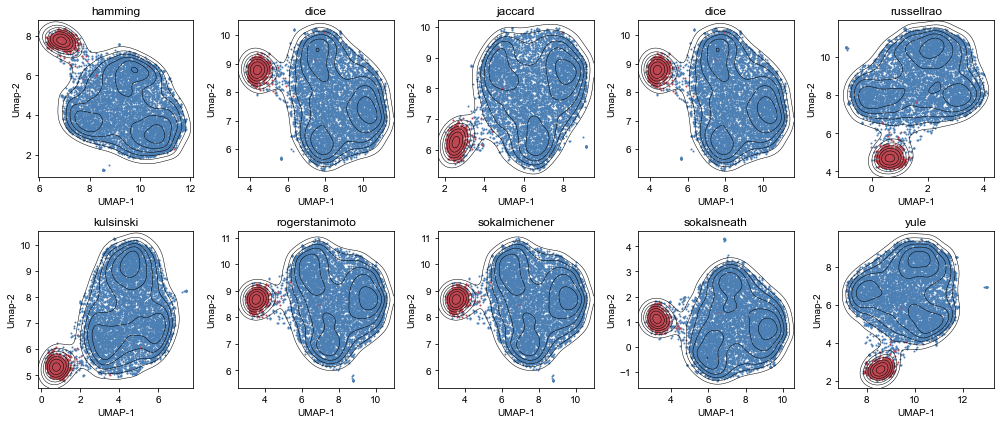

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(14,6))
for ax, df, m in zip(*[axes.reshape(-1), UMAP_out2, metrics_set2]):
    draw_clusters(ax, df, "UMAP-1", "Umap-2", m)
plt.tight_layout()
plt.savefig("Decomposition_UMAP_metrics.binary.pdf")

### 4.3 Draw time usage and memory usage

In [23]:
metrics_group = ["Minkowski-style"] * 4 * 3 + ["Binary"] * 10 * 3
metrics_set_items = []
for i in metrics_set1:
    metrics_set_items.extend([i] * 3)
for i in metrics_set2:
    metrics_set_items.extend([i] * 3)
    
print(len(metrics_group))
print(len(metrics_group))
print(len(Time_out + Time_out2))
print(len(MEM_out+MEM_out2))
df_metrics_performance = pd.DataFrame(np.stack([metrics_set_items, metrics_group, Time_out + Time_out2, MEM_out+MEM_out2], axis=1), columns=["Metric", "Type", "Time (sec)", "Peak Memory (MB)"])
print(df_metrics_performance)
df_metrics_performance["Time (sec)"] = df_metrics_performance["Time (sec)"].astype(float)
df_metrics_performance["Peak Memory (MB)"] = df_metrics_performance["Peak Memory (MB)"].astype(float)
print(df_metrics_performance)
df_metrics_performance.to_csv("UMAP_metrics_performance.csv")

42
42
42
42
            Metric             Type          Time (sec)    Peak Memory (MB)
0        euclidean  Minkowski-style   27.52726459503174   87.18525981903076
1        euclidean  Minkowski-style  27.627380847930908   75.08754253387451
2        euclidean  Minkowski-style  27.782577514648438   69.09958457946777
3        manhattan  Minkowski-style    37.7425012588501   76.67847061157227
4        manhattan  Minkowski-style  27.242331981658936   61.76513957977295
5        manhattan  Minkowski-style   27.74483871459961   57.21544361114502
6        minkowski  Minkowski-style  37.420175552368164   68.66375064849854
7        minkowski  Minkowski-style  27.146674394607544   53.54033088684082
8        minkowski  Minkowski-style  27.540719509124756   47.14650535583496
9        chebyshev  Minkowski-style   84.23543953895569   93.25289916992188
10       chebyshev  Minkowski-style   73.67953896522522   82.14410209655762
11       chebyshev  Minkowski-style   73.98842167854309   82.13854694366455


In [ ]:
tracemalloc.stop()

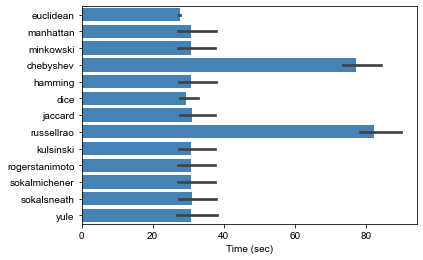

In [30]:
fig, ax = plt.subplots()

sns.barplot(data=df_metrics_performance, y="Metric", x="Time (sec)", ax=ax, saturation=1, orient="h", color="steelblue")
ax.set_ylabel("")
ax.set_xlabel("Time (sec)")
plt.savefig("Decomposition_UMAP_metrics_time.pdf")

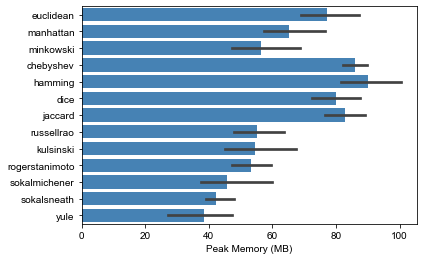

In [31]:
fig, ax = plt.subplots()

sns.barplot(data=df_metrics_performance, y="Metric", x="Peak Memory (MB)", ax=ax, saturation=1, orient="h", color="steelblue")
ax.set_ylabel("")
ax.set_xlabel("Peak Memory (MB)")
plt.savefig("Decomposition_UMAP_metrics_RAM.pdf")

## Summary

UMAP is the best choice for us handling one-hot encoded fasta sequences. Although DensMAP also genrate perfect results, however, it is not suitable in distinguishing some motifs highly similar to each other (see `HeLa_Noc` notebook). PCA, is just a reference in this analysis, beacuse we know that such a statistical methods is limitted and can easily make errors. t-SNE, once popular in single-cell analysis, will break the spatial relationship in some clusters.

Among the metrics we tested, the default (`euclidean`) works perfectly. Other metrics, except for `chebyshev`, work equally. But in most of the cases, binary metrics require much more memory.

Note that, `minkowski` is the default metric in RAPIDS.
